In [1]:
!pip install mediapipe

In [2]:
!pip install py-feat

In [3]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
# import dependencies for MediaPipe
import mediapipe as mp

mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

ModuleNotFoundError: No module named 'google.colab'

# If you only want to test the Py-FEAT on a static face image then skip to the cell "Example of using Py-FEAT for feature extraction"

# Applying meshes to faces using MediaPipe in video streams

In [ ]:
# video streaming code snippet from >> https://github.com/theAIGuysCode/colab-webcam

# JavaScript object into OpenCV image
def js_to_image(js_reply):
  """
  Params: js_reply: JavaScript object containing image from webcam
  Returns: img: OpenCV BGR image
  """
  image_bytes = b64decode(js_reply.split(',')[1]) # decode base64 image
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8) # bytes to np
  img = cv2.imdecode(jpg_as_np, flags=1) # BGR image
  return img

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, image):
  data = eval_js('stream_frame("{}", "{}")'.format(label, image))
  return data

In [ ]:
def img_to_bytes(image):
  image_PIL = PIL.Image.fromarray(image, 'RGB')
  iobuf = io.BytesIO()
  # format bbox into png for return
  image_PIL.save(iobuf, format='png')
  # format return string
  image_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
  return image_bytes

The apply_mesh() function uses the MediaPipe pipeline
to find the face inside an image, its landmarks
and draws the landmarks, the tesselation and the left and right iris.

In [ ]:
# code snippet for applying mesh from >> https://mediapipe.page.link/face_mesh_py_colab

def apply_mesh(image, return_ldm: bool = False):
  """
  input
    image: np image in bgr format
  output
    annotated_image: np image in rgb
  """
  out_dict = {}
  with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    refine_landmarks=True,
    max_num_faces=2,
    min_detection_confidence=0.5) as face_mesh:

    # MediaPipe Face Mesh to get landmarks
    # process() returns a list of landmarks (x,y,z) coordinates 
    # which you can access by ".multi_face_landmarks"
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
    # Draw face landmarks of face.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_face_landmarks:
      for face_landmarks in results.multi_face_landmarks:
        # draw_landmarks function needs an RGB image
        # and the retrieved landmarks
        mp_drawing.draw_landmarks(
          image=image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_TESSELATION,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing.DrawingSpec(color=(102, 255, 102), thickness=1, circle_radius=1)
          )
        mp_drawing.draw_landmarks(
          image=image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_CONTOURS,
          landmark_drawing_spec= None, #mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=1),
          connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=1)
          )
        mp_drawing.draw_landmarks(
          image=image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1),
          connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1)
          #connection_drawing_spec=mp_drawing_styles
          #.get_default_face_mesh_iris_connections_style()
          )
    # apply segmentation mask, source: https://google.github.io/mediapipe/solutions/selfie_segmentation.html
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results_segmentation = selfie_segmentation.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # condition = np.stack((results_segmentation.segmentation_mask,) * 3, axis=-1) > 0.05
    # bg_image = np.zeros(image.shape, dtype=np.uint8)
    # bg_image[:] = (0, 237, 63)  # BG color
    # image = np.where(condition, image, bg_image)
    out_dict['img'] = cv2.flip(image, 1)
    if return_ldm:
      out_dict['img_ldm'] = results.multi_face_landmarks
  return out_dict, results

To obtain the landmarks, you have to access the "multi_face_landmarks" from the FaceMesh class.

The next cell starts the video stream and applies a mesh on top of your face.

In [ ]:
# start streaming video from webcam
video_stream()

# label for video
label_html = 'Capturing...'
img = ""
landmk = ""
while True:
  js_reply = video_frame(label_html, img)
  if not js_reply:
      break
  img = js_to_image(js_reply["img"])
  img_dict, results = apply_mesh(img, True)
  landmk = img_dict['img_ldm']
  img_mesh = img_dict["img"]
  img_mesh = img_to_bytes(img_mesh)
  img = img_mesh

print(landmk)

MessageError: ignored

# Example of using Py-FEAT for feature extraction

run this cell nr. 7 and upload an face image with a facial expression

In [ ]:
from feat.detector import Detector
from google.colab import files

# upload an image yout want to process
uploaded = files.upload()


Saving WIN_20211220_23_13_55_Pro.jpg to WIN_20211220_23_13_55_Pro.jpg


The next cell initializes the Detector class 

Loading Face Detection model:  retinaface
Using downloaded and verified file: /usr/local/lib/python3.7/dist-packages/feat/resources/mobilenet0.25_Final.pth
Using downloaded and verified file: /usr/local/lib/python3.7/dist-packages/feat/resources/mobilenet_224_model_best_gdconv_external.pth.tar
Using downloaded and verified file: /usr/local/lib/python3.7/dist-packages/feat/resources/hog_pca_all_emotio.joblib
Using downloaded and verified file: /usr/local/lib/python3.7/dist-packages/feat/resources/hog_pca_all_emotio.joblib
Using downloaded and verified file: /usr/local/lib/python3.7/dist-packages/feat/resources/hog_scalar_aus.joblib
Using downloaded and verified file: /usr/local/lib/python3.7/dist-packages/feat/resources/RF_568.joblib
Using downloaded and verified file: /usr/local/lib/python3.7/dist-packages/feat/resources/hog_pca_all_emotio.joblib
Using downloaded and verified file: /usr/local/lib/python3.7/dist-packages/feat/resources/hog_scalar_aus.joblib
Using downloaded and verified

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator PCA from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your

Loading emotion model:  resmasknet


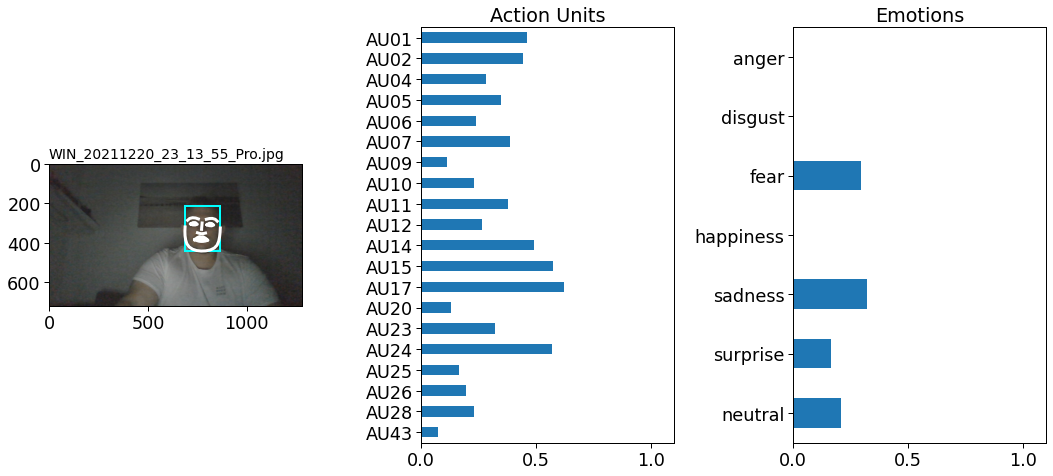

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd926eb8750>,
      dtype=object)

In [ ]:

#upl_img = cv2.imread('dav.jpg')
detector = Detector()
results = detector.detect_image("WIN_20211220_23_13_55_Pro.jpg")
results.plot_detections()